## Імпорт бібліотек

In [ ]:
!pip install nlpaug

In [ ]:
!pip install pydub

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import re
import os
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.word as naw
import librosa
import soundfile as sf
import math
import noisereduce as nr
from scipy.io import wavfile
import ast
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import string
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import norm
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Input, Concatenate, Dense, Reshape, Conv1D, BatchNormalization, Bidirectional,
    LSTM, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Попередня обробка

### Виокремлення реплік учасників

Фільтрація реплік учасників для записів з розширеного набору даних EDAIC-WoZ здійснюється вручну напочатку. Для записів з основного набору даних DAIC-WoZ (participant_id < 600) фільтруються репліки, позначені в транскриптах як ті, що належать учаснику. Текст реплік об'єднується, аудіо реплік об'єднується на основі часових позначок відповідної репліки.

In [ ]:
# Функція для зчитування даних та об'єднання тексту і аудіо для учасників зі списку
def process_participant_data(base_dir, participants_file, output_dir):
    # Зчитуємо файл зі списком номерів учасників
    with open(participants_file, 'r') as f:
        valid_participants = f.read().splitlines()  # Створюємо список номерів учасників

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith("_TRANSCRIPT.csv"):
                participant_id = file.split('_')[0]

                if participant_id in valid_participants:
                    transcript_path = os.path.join(root, file)

                    audio_file = f"{participant_id}_AUDIO.wav"
                    audio_path = os.path.join(root, audio_file)

                    if os.path.exists(audio_path):
                        print(f"Обробляється учасник: {participant_id}")
                        if int(participant_id) < 600: # Записи з основного набору DAIC

                            transcript_df = pd.read_csv(transcript_path, sep="\t")
                            participant_replies = transcript_df[transcript_df['speaker'] == 'Participant']
                            combined_replies = " ".join(participant_replies['value'].astype(str).fillna(''))

                            start_times = participant_replies['start_time'].tolist()
                            stop_times = participant_replies['stop_time'].tolist()
                        else: # Записи з додаткового набору EDAIC
                            transcript_df = pd.read_csv(transcript_path)
                            combined_replies = " ".join(transcript_df['Text'])

                            start_times = transcript_df['Start_Time'].tolist()
                            stop_times = transcript_df['End_Time'].tolist()

                        audio = AudioSegment.from_wav(audio_path)
                        combined_audio = AudioSegment.empty()

                        # Обрізаємо частини аудіо для кожної репліки та об'єднуємо в одне аудіо
                        for start, stop in zip(start_times, stop_times):
                            start_ms = start * 1000
                            stop_ms = stop * 1000
                            combined_audio += audio[start_ms:stop_ms]

                        output_text_file = os.path.join(output_dir, f"{participant_id}_combined_replies.txt")
                        output_audio_file = os.path.join(output_dir, f"{participant_id}_combined_audio.wav")

                        with open(output_text_file, "w") as text_file:
                            text_file.write(combined_replies)

                        combined_audio.export(output_audio_file, format="wav")

                        print(f"Збережено для учасника {participant_id}: текст та аудіо")
                    else:
                        print(f"Відсутнє аудіо для учасника {participant_id}")
                else:
                    print(f"Учасник {participant_id} не включений у список")

In [ ]:
base_dir = "/content/drive/MyDrive/diploma_data/data"
participants_file = "valid_participants.txt"  # Файл зі списком ID усіх учасників
output_dir = "/content/drive/MyDrive/diploma_data/participant_data"  # Папка для збереження результатів
process_participant_data(base_dir, participants_file, output_dir)


Здійснюється рівномірний розподіл даних (ID учасників) на тренувальну та тестову вибірки. Створюється датафрейм з інформацією про належність до вибірки та класу (наявність чи відсутність депресії).

In [ ]:
# Зчитуємо текстовий файл з ID пацієнтів
with open('/content/valid_participants.txt', 'r') as file:
    patient_ids = [int(line.strip()) for line in file]

# Зчитуємо CSV файл з інформацією про класи
labels_df = pd.read_csv('/content/drive/MyDrive/diploma_data/labels/new_detailed_lables.csv')  # CSV файл з колонками 'Patient_ID' і 'Depression_label'

labels_df = labels_df[labels_df['Participant'].isin(patient_ids)]

train_ids, test_ids = train_test_split(labels_df, test_size=0.2, stratify=labels_df['Depression_label'], random_state=42)

train_participant_ids = train_ids['Participant'].tolist()
test_participant_ids = test_ids['Participant'].tolist()

print(f"Кількість пацієнтів у тренувальній вибірці: {len(train_participant_ids)}")
print(f"Кількість пацієнтів у тестовій вибірці: {len(test_participant_ids)}")

train_df = pd.DataFrame({'Patient_ID': train_participant_ids, 'Set': 'train'})
test_df = pd.DataFrame({'Patient_ID': test_participant_ids, 'Set': 'test'})

train_df['Depression_label'] = labels_df.set_index('Participant').loc[train_participant_ids, 'Depression_label'].values
test_df['Depression_label'] = labels_df.set_index('Participant').loc[test_participant_ids, 'Depression_label'].values

print(train_df.head())
print(test_df.head())

split_df = pd.concat([train_df, test_df])

split_df.to_csv('participant_split.csv', index=False)

print("Розподіл на тренувальну і тестову вибірки збережено у participant_split.csv")

Кількість пацієнтів у тренувальній вибірці: 171
Кількість пацієнтів у тестовій вибірці: 43
   Patient_ID    Set  Depression_label
0         443  train                 0
1         390  train                 0
2         331  train                 0
3         359  train                 1
4         456  train                 0
   Patient_ID   Set  Depression_label
0         426  test                 1
1         699  test                 1
2         637  test                 1
3         427  test                 0
4         387  test                 0
Розподіл на тренувальну і тестову вибірки збережено у participant_split.csv


### Аугментація навчальних даних

Аугментація навчальних даних (з класом наявності депресії). Текст обробляється частинами по 100 слів, ймовірність заміни слів на синоніми складає 15%. Для аудіо даних змінюється тональність на 1.5 півтона

In [ ]:
# Функція для аугментації тексту (заміна на синоніми з виключенням важливих слів)
def augment_text_in_chunks(text, chunk_size=100, aug_p=0.15):
    words = text.split()
    chunks = [words[i:i + chunk_size] for i in range(0, len(words), chunk_size)]

    # Стоп-слова, які не будуть замінюватись
    stopwords = ['i', 'me', 'my', 'you', 'not', 'never', 'don\'t', 'doesn\'t',
                 'depression', 'depressed', 'anxiety', 'tired', 'sad', 'hopeless', 'lonely', 'mm', 'it']

    aug = naw.SynonymAug(aug_src='wordnet', aug_p=aug_p, stopwords=stopwords)
    augmented_chunks = []
    for chunk in chunks:
        augmented_chunk = aug.augment(' '.join(chunk))
        if isinstance(augmented_chunk, list):
            augmented_chunks.append(' '.join(augmented_chunk))
        else:
            augmented_chunks.append(augmented_chunk)
    augmented_text = ' '.join(augmented_chunks)

    return augmented_text

# Функція для аугментації аудіо (зміна тону)
def change_pitch_librosa(audio_path, output_path, n_steps=1.5):
    y, sr = librosa.load(audio_path, sr=16000)
    y_shifted = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)
    sf.write(output_path, y_shifted, sr)

# Функція для аугментації навчальних даних і збереження результатів в ту саму папку
def augment_and_save_data(audio_dir, split_df, transcript_dir):
    train_ids = split_df[split_df['Set'] == 'train']['Patient_ID'].tolist()

    for root, dirs, files in os.walk(audio_dir):
        for file in files:
            if file.endswith("_combined_audio.wav"):
                participant_id = int(file.split('_')[0])

                row = split_df[split_df['Patient_ID'] == participant_id]
                if not row.empty:
                    label = row['Depression_label'].values[0]

                    if participant_id in train_ids and label == 1:
                        print(f"Аугментація пацієнта {participant_id}...")

                        # Аугментація тексту
                        transcript_file = os.path.join(transcript_dir, f"{participant_id}_combined_replies.txt")
                        if os.path.exists(transcript_file):
                            with open(transcript_file, 'r') as f:
                                text = f.read()
                            augmented_text = augment_text(text)
                            augmented_text_path = os.path.join(root, f"{participant_id}_combined_replies_augmented.txt")
                            with open(augmented_text_path, "w") as f:
                                f.write(augmented_text)

                        # Аугментація аудіо
                        audio_file = os.path.join(root, file)
                        augmented_audio_path = os.path.join(root, f"{participant_id}_combined_audio_augmented.wav")
                        change_pitch_librosa(audio_file, augmented_audio_path)

                        print(f"Пацієнт {participant_id}: аугментовані дані збережено у ту саму папку.")


In [ ]:
audio_dir = "/content/drive/MyDrive/diploma_data/participant_data"
transcript_dir = "/content/drive/MyDrive/diploma_data/participant_data"
split_df = pd.read_csv("/content/participant_split.csv")

augment_and_save_data(audio_dir, split_df, transcript_dir)

### Сегментація даних

Текст та аудіо діляться на сегменти. З аудіо даних видаляються сторонні шуми, після чого записи діляться на сегменти тривалістю 1 хв. На основі кількості сегментів при поділі аудіо даних, текст ділиться на таку ж кількість сегментів за кількістю слів.

In [ ]:
# Функція для видалення шумів з аудіо
def denoise_audio(audio_path):
    rate, data = wavfile.read(audio_path)
    reduced_noise = nr.reduce_noise(y=data, sr=rate)
    temp_path = "temp_denoised.wav" # Збереження очищеного аудіо як тимчасовий файл
    wavfile.write(temp_path, rate, reduced_noise)
    return temp_path

# Функція для поділу аудіо на сегменти з мінімальною тривалістю
def split_audio_with_min_duration(audio_path, segment_length=10, min_duration=15):
    denoised_path = denoise_audio(audio_path)
    audio = AudioSegment.from_wav(denoised_path)
    total_duration = len(audio) / 1000  # Тривалість у секундах
    num_segments = math.ceil(total_duration / segment_length)  # Кількість сегментів
    segments = []

    for i in range(num_segments):
        start = i * segment_length * 1000  # Конвертуємо в мілісекунди
        end = min((i + 1) * segment_length * 1000, len(audio))
        segment = audio[start:end]

        # Якщо сегмент довший за мінімальний поріг, додаємо його
        if len(segment) / 1000 >= min_duration:
            segments.append(segment)

    return segments

# Функція для поділу тексту на сегменти
def split_text_equal_parts(transcript_file, num_segments):
    with open(transcript_file, 'r', encoding='utf-8') as f:
        all_text = f.read().strip()

    words = all_text.split()
    words_per_segment = math.ceil(len(words) / num_segments)  # Кількість слів на сегмент

    text_segments = []
    for i in range(num_segments):
        start = i * words_per_segment
        end = min((i + 1) * words_per_segment, len(words))
        segment = " ".join(words[start:end])
        text_segments.append(segment)

    return text_segments

# Функція для зчитування і поділу навчальних аудіо та тексту з додаванням ID учасника та класу
def process_audio_text_segments(audio_dir, transcript_dir, split_df, segment_length=60, min_duration=20, set_mode):
    data_segments = []

    ids = split_df[split_df['Set'] == set_mode]['Patient_ID'].tolist()

    for root, dirs, files in os.walk(audio_dir):
        for file in files:
            if file.endswith("_combined_audio.wav") or file.endswith("_combined_audio_augmented.wav"):
                participant_id = int(file.split('_')[0])

                if participant_id in ids:
                    transcript_file = file.replace("_combined_audio.wav", "_combined_replies.txt").replace("_combined_audio_augmented.wav", "_combined_replies_augmented.txt")
                    transcript_file = os.path.join(transcript_dir, transcript_file)

                    # Поділ аудіо на сегменти
                    audio_file = os.path.join(root, file)
                    audio_segments = split_audio_with_min_duration(audio_file, segment_length=segment_length, min_duration=min_duration)

                    # Поділ тексту на сегменти
                    if os.path.exists(transcript_file):
                        text_segments = split_text_equal_parts(transcript_file, len(audio_segments))

                        # Додаємо інформацію про клас та учасника
                        depression_label = split_df[split_df['Patient_ID'] == participant_id]['Depression_label'].values[0]

                        for i in range(len(audio_segments)):
                            data_segments.append({
                                'Patient_ID': participant_id,
                                'Segment_ID': i + 1,
                                'Depression_label': depression_label,
                                'Audio_Segment': audio_segments[i],
                                'Text_Segment': text_segments[i]
                            })

    return pd.DataFrame(data_segments)


In [ ]:
audio_dir = "/content/drive/MyDrive/diploma_data/participant_data"
transcript_dir = "/content/drive/MyDrive/diploma_data/participant_data"
split_df = pd.read_csv("/content/participant_split.csv")

segments_df = process_audio_text_segments(audio_dir, transcript_dir, split_df, segment_length=60, min_duration=30, 'train')
segments_test_df = process_audio_text_segments(audio_dir, transcript_dir, split_df, segment_length=60, min_duration=30, 'test')

In [ ]:
segment_counts = segments_df['Depression_label'].value_counts()

segment_counts

,count
Depression_label,
0,905
1,730


### Збалансування класів

Збалансування класів шляхом випадкового вибору сегментів для класу 0 у кількості, рівній кількості класу 1

In [ ]:
class_1_segments = segments_df[segments_df['Depression_label'] == 1]

# Вибираємо рандомні сегменти для класу 0 у кількості, рівній кількості класу 1
class_0_segments = segments_df[segments_df['Depression_label'] == 0].sample(n=len(class_1_segments), random_state=42)

balanced_df = pd.concat([class_1_segments, class_0_segments])

# Перемішуємо об'єднані сегменти, щоб уникнути впливу порядку
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['Depression_label'].value_counts())

Depression_label
0    730
1    730
Name: count, dtype: int64


In [ ]:
balanced_df

,Patient_ID,Segment_ID,Depression_label,Audio_Segment,Text_Segment
0,374,6,0,(((<pydub.audio_segment.AudioSegment object at...,get me very angry it doesn't happen very often...
1,414,4,1,(((<pydub.audio_segment.AudioSegment object at...,and just would've stopped there and not have l...
2,345,3,1,(((<pydub.audio_segment.AudioSegment object at...,my mom and sister yesterday it was just someth...
3,311,2,1,(((<pydub.audio_segment.AudioSegment object at...,now i live in an apartment uh i don't i don't ...
4,491,5,0,(((<pydub.audio_segment.AudioSegment object at...,to do what was right according to what god wou...
...,...,...,...,...,...
725,636,9,1,(((<pydub.audio_segment.AudioSegment object at...,these threats in the e-mails back like oh yeah...
726,600,2,1,(((<pydub.audio_segment.AudioSegment object at...,me I'm not attending therapy right now I'm not...
727,350,4,1,(((<pydub.audio_segment.AudioSegment object at...,despite the types of things that we've gone th...
728,434,10,0,(((<pydub.audio_segment.AudioSegment object at...,no one will even know that i didn't get much s...


### Обчислення аудіо ознак

In [ ]:
# Функція для витягування аудіо ознак з сегмента
def extract_audio_features_from_segment(y, sr=16000):
    # 1. MFCC (Мел-кепстральні коефіцієнти)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # 2. Spectral Contrast (Спектральний контраст)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

    # 3. Mel-spectrogram (Мел-спектрограма)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80)
    mel_spec_mean = np.mean(mel_spec, axis=1)

    return {
        'mfcc_mean': mfcc_mean,
        'spectral_contrast_mean': spectral_contrast_mean,
        'mel_spec_mean': mel_spec_mean,
    }

# Функція для обчислення ознак для аудіосегментів
def analyze_audio_segments(balanced_df, mode='train'):
    analysis_results = []

    for index, row in balanced_df.iterrows():
        audio_segment = row['Audio_Segment']
        label = row['Depression_label']

        y = np.array(audio_segment.get_array_of_samples(), dtype=np.float32)
        sr = audio_segment.frame_rate

        features = extract_audio_features_from_segment(y, sr=sr)

        features['segment_id'] = index
        features['depression_label'] = label
        if mode == 'test':
          patient_id = row['Patient_ID']
          features['patient_id'] = patient_id

        analysis_results.append(features)


    results_df = pd.DataFrame(analysis_results)
    return results_df

In [ ]:
audio_features_df = analyze_audio_segments(balanced_df)
audio_features_test_df = analyze_audio_segments(segments_test_df, mode='test')

In [ ]:
audio_features_df[['mfcc_mean', 'spectral_contrast_mean', 'mel_spec_mean', 'depression_label']]

,mfcc_mean,spectral_contrast_mean,mel_spec_mean,depression_label
0,"[570.1031, 128.70393, 3.670262, 23.25678, -9.3...","[19.37590638163838, 16.07774032774062, 18.9339...","[11579162.0, 39117428.0, 31060382.0, 43655292....",0
1,"[544.19, 101.52989, -3.5436854, 14.868433, -8....","[21.376128838363865, 21.384391768546735, 21.08...","[10104887.0, 1006402.06, 899765.4, 41747690.0,...",0
2,"[504.41306, 129.37822, -8.188198, 21.22656, -2...","[19.168789197086866, 16.261954408458006, 18.77...","[11426013.0, 6647653.0, 41238532.0, 43776496.0...",1
3,"[519.1214, 112.17602, 18.452267, 8.230405, 3.1...","[20.54264521329731, 15.78014350116916, 17.9971...","[10573855.0, 4231969.0, 143855660.0, 201051490...",1
4,"[646.872, 108.36707, 2.6288092, 16.358454, -4....","[19.145134244682776, 17.991024608577224, 20.09...","[1449285500.0, 662050560.0, 229388130.0, 36630...",0
...,...,...,...,...
1455,"[513.19586, 95.486694, 14.263907, 23.145115, 9...","[18.798547545088955, 14.363445137770368, 16.20...","[168834140.0, 259314400.0, 449539100.0, 345199...",0
1456,"[611.0082, 120.8569, -19.689264, 18.34895, 3.0...","[19.90841468496577, 17.706397671131242, 19.348...","[6647814.5, 31567356.0, 191083100.0, 107444590...",0
1457,"[476.43716, 108.09354, 2.348658, 21.197544, -2...","[21.573404813036568, 17.24246826662884, 19.450...","[23242582.0, 345667.94, 547022.25, 11602352.0,...",0
1458,"[568.15967, 120.00197, -6.0037246, 22.45985, 0...","[18.51555614518317, 17.802590023266763, 20.301...","[18568762.0, 4633226.5, 1608986.5, 14024919.0,...",0


In [ ]:
audio_features_df.to_csv("/content/drive/MyDrive/diploma_data/audio_features.csv", index=False)
audio_features_test_df.to_csv("/content/drive/MyDrive/diploma_data/audio_features_test.csv", index=False)

In [ ]:
audio_features_df = pd.read_csv('/content/drive/MyDrive/diploma_data/audio_features.csv')
audio_features_test_df = pd.read_csv('/content/drive/MyDrive/diploma_data/audio_features_test.csv')

In [ ]:
# Функція для додавання ком між числами
def fix_missing_commas(text):
    if not isinstance(text, str):
        return text
    fixed_text = re.sub(r"(\d)\s+(\d)", r"\1, \2", text)
    return fixed_text

# Функція для виправлення та перетворення стовпця
def fix_and_unpack_column_inplace(df, column_name, num_elements, prefix):
    df[column_name] = df[column_name].apply(fix_missing_commas)

    df[column_name] = df[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Розпаковуємо списки у окремі стовпці
    new_columns = [prefix + str(i) for i in range(1, num_elements + 1)]
    df[new_columns] = pd.DataFrame(df[column_name].tolist(), index=df.index)

# Розпаковуємо мел-спектрограми (80 елементів)
fix_and_unpack_column_inplace(audio_features_df, 'mel_spec_mean', 80, 'mel_spec_mean_')
fix_and_unpack_column_inplace(audio_features_test_df, 'mel_spec_mean', 80, 'mel_spec_mean_')

# Розпаковуємо MFCC (13 елементів)
fix_and_unpack_column_inplace(audio_features_df, 'mfcc_mean', 13, 'mfcc_mean_')
fix_and_unpack_column_inplace(audio_features_test_df, 'mfcc_mean', 13, 'mfcc_mean_')

# Розпаковуємо spectral contrast (7 елементів)
fix_and_unpack_column_inplace(audio_features_df, 'spectral_contrast_mean', 7, 'spectral_contrast_mean_')
fix_and_unpack_column_inplace(audio_features_test_df, 'spectral_contrast_mean', 7, 'spectral_contrast_mean_')

In [ ]:
mel_mean_columns = ['mel_spec_mean_' + str(i) for i in range(1, 81)]
mfcc_mean_columns = ['mfcc_mean_' + str(i) for i in range(1, 14)]
spectral_contrast_mean_columns = ['spectral_contrast_mean_' + str(i) for i in range(1, 8)]
features_columns = mel_mean_columns + spectral_contrast_mean_columns + mfcc_mean_columns
X_audio = audio_features_df[features_columns].values
X_audio_test = audio_features_test_df[features_columns].values
y_audio = audio_features_df['depression_label'].values

In [ ]:
scaler = StandardScaler()
X_audio = scaler.fit_transform(X_audio)
X_audio_test = scaler.transform(X_audio_test)

### Попередня обробка текстових ознак

In [ ]:
def handle_negations(text):
    # Замінюємо скорочені форми на повні заперечення
    text = re.sub(r"\b(isn't)\b", "is not", text)
    text = re.sub(r"\b(wasn't)\b", "was not", text)
    text = re.sub(r"\b(aren't)\b", "are not", text)
    text = re.sub(r"\b(weren't)\b", "were not", text)
    text = re.sub(r"\b(don't)\b", "do not", text)
    text = re.sub(r"\b(doesn't)\b", "does not", text)
    text = re.sub(r"\b(didn't)\b", "did not", text)
    text = re.sub(r"\b(can't)\b", "cannot", text)
    text = re.sub(r"\b(couldn't)\b", "could not", text)
    text = re.sub(r"\b(shouldn't)\b", "should not", text)
    text = re.sub(r"\b(wouldn't)\b", "would not", text)
    text = re.sub(r"\b(haven't)\b", "have not", text)
    text = re.sub(r"\b(hasn't)\b", "has not", text)
    text = re.sub(r"\b(hadn't)\b", "had not", text)
    text = re.sub(r"\b(won't)\b", "will not", text)

    return text

In [ ]:
balanced_df['Text_Segment'] = balanced_df['Text_Segment'].apply(handle_negations)
segments_test_df['Text_Segment'] = segments_test_df['Text_Segment'].apply(handle_negations)

In [ ]:
def preprocess(text):
    text = re.sub(r"<.*?>", "", text) # Видалення всіх слів між <>
    text = re.sub("[\d]","", text) # видалення цифр
    text = text.lower()
    words = text.split()
    sentence = ""
    for word in words:
         if len(word) > 1: # враховуються слова з довжиною більше 1 символу
            sentence = sentence + word + ' '
    return(sentence)

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
balanced_df['Text_Segment'] = balanced_df['Text_Segment'].apply(lambda s : preprocess(s))
segments_test_df['Text_Segment'] = segments_test_df['Text_Segment'].apply(lambda s : preprocess(s))

In [ ]:
balanced_df['Text_Segment'].head(10)

,Text_Segment
0,places but that takes awhile to afford so we v...
1,sure well thank you southern california the we...
2,hard for me to focus um not really but can exp...
3,know send her texts periodically but uh most o...
4,hardest decision ve ever had to make the harde...
5,and heavy snorer snore like chainsaw so there ...
6,so um yeah the psychology definitely comes int...
7,yes okay feeling little tired and uh worried u...
8,fragile and think they re pains in the asses m...
9,but other than that no hmm hmm not sure it wou...


### Обчислення текстових ознак

Обчислюються текстові ознаки шляхом збільшення ваги слів, пов'язаних з депресією, та застосування методу TF-IDF.

In [ ]:
# Завантажуємо GloVe вектори
glove_path = "/content/glove.6B.100d.txt"  # Замініть на свій шлях
embeddings_index = {}

with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Завантажено {len(embeddings_index)} векторів слів.")

Завантажено 400000 векторів слів.


In [ ]:
depression_keywords = ["hopeless", "tired", "worthless", "sad", "lonely", "depressed", "depression", "unhappy",
                       "guilty", "disappointed", "anxious", "fatigue", "suicidal", "suicide"]

In [ ]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

In [ ]:
def find_similar_words(target_word, embeddings_index, top_n=10):
    target_vector = embeddings_index.get(target_word)
    if target_vector is None:
        return []

    # Обчислення подібності до кожного слова у словнику GloVe
    similarities = {}
    for word, vector in embeddings_index.items():
        similarity = cosine_similarity(target_vector, vector)
        similarities[word] = similarity

    # Сортування за подібністю і повернення топ-N слів
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_similarities[:top_n]

In [ ]:
boosted_words = set(depression_keywords)  # Використовуємо set, щоб уникнути дублювання слів

# Додаємо схожі слова до початкового списку
for keyword in depression_keywords:
    similar_words = find_similar_words(keyword, embeddings_index)
    for word, similarity in similar_words:
        boosted_words.add(word)

In [ ]:
boosted_words = list(boosted_words)

print("Список boosted_words:", boosted_words)

Список boosted_words: ['depression', 'acquitted', 'fearful', 'hopeless', 'exhaustion', 'anxious', 'nausea', 'killed', 'nervous', 'overpriced', 'homicidal', 'pathetic', 'helpless', 'unreadable', 'psychosis', 'illness', 'paranoid', 'bored', 'uncomfortable', 'restless', 'bomb', 'pleased', 'dissatisfied', 'suicidal', 'meaningless', 'negotiable', 'scared', 'chronic', 'sickness', 'worthless', 'impatient', 'utterly', 'distressed', 'surprised', 'onset', 'psychotic', 'miserable', 'hesitant', 'alcoholism', 'discomfort', 'irrelevant', 'eager', 'desolate', 'disappointed', 'lonely', 'bombing', 'terrible', 'mental', 'sad', 'satisfied', 'weak', 'useless', 'murder', 'attack', 'poignant', 'awful', 'pleaded', 'thrilled', 'tiredness', 'heartbreaking', 'charges', 'conviction', 'unstable', 'charged', 'killing', 'murderous', 'guilty', 'horrible', 'ideation', 'insecure', 'bomber', 'tragic', 'wary', 'shocked', 'sorry', 'haunted', 'worried', 'unusable', 'self-destructive', 'schizophrenia', 'fatigue', 'valueles

In [ ]:
# Видалення зі списку слів, які не пов'язані з депресією
words_to_remove = ['pleased', 'bit', 'overpriced', 'negotiable', 'impotent',
                   'utterly', 'eager', 'delighted', 'feel', 'happy',
                   'mental', 'satisfied', 'ideation']

boosted_words = [word for word in boosted_words if word not in words_to_remove]

In [ ]:
len(boosted_words)

109

In [ ]:
texts = balanced_df['Text_Segment'].tolist()  # Колонка з текстом
labels = balanced_df['Depression_label'].tolist()  # Колонка з мітками

In [ ]:
test_texts = segments_test_df['Text_Segment'].tolist()  # Колонка з текстом
test_labels = segments_test_df['Depression_label'].tolist()  # Колонка з мітками

In [ ]:
# Функція для збільшення ваги важливих слів
def boost_important_words(text, keywords, boost_factor=2):
    words = text.split()
    boosted_text = []
    for word in words:
        if word in keywords:
            # Подвоюємо вагу слова, повторивши його кілька разів
            boosted_text.extend([word] * boost_factor)
        else:
            boosted_text.append(word)
    return " ".join(boosted_text)

boosted_texts = [boost_important_words(text, boosted_words) for text in texts]

In [ ]:
# Використовуємо TF-IDF для перетворення тексту в ознаки
vectorizer = TfidfVectorizer(max_features = 3000)
X_text = vectorizer.fit_transform(boosted_texts).toarray()
X_text_test = vectorizer.transform(test_texts).toarray()

In [ ]:
X_text.shape

(1460, 3000)

In [ ]:
X_text_test.shape

(341, 3000)

## Модель раннього злиття

In [ ]:
# Ділимо дані на тренувальні та валідаційні набори
X_audio_train, X_audio_val, X_text_train, X_text_val, y_train, y_val = train_test_split(
    X_audio, X_text, y_audio, test_size=0.2, random_state=42)

In [ ]:
# Функція для додавання механізму самоуваги (self-attention)
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.3)

    def call(self, inputs):
        attn_output = self.multi_head_attention(inputs, inputs)
        attn_output = self.dropout(attn_output)
        return self.layernorm(inputs + attn_output)

# Модель із раннім ф'южном
def create_early_fusion_model(audio_input_shape, text_input_shape):
    audio_inputs = Input(shape=audio_input_shape)
    text_inputs = Input(shape=text_input_shape)
    combined_inputs = Concatenate()([audio_inputs, text_inputs])
    x = Dense(128, activation='relu')(combined_inputs)
    x = Reshape((128, 1))(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Reshape((1, -1))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = SelfAttention(embed_dim=64, num_heads=4)(x)
    x = GlobalAveragePooling1D()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[audio_inputs, text_inputs], outputs=outputs)
    return model

# Вхідні форми даних
audio_input_shape = (100,)
text_input_shape = (3000,)

early_model = create_early_fusion_model(audio_input_shape, text_input_shape)
learning_rate = 0.00001

optimizer = Adam(learning_rate=learning_rate)

early_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_21            │ (None, 3000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 3100)           │              0 │ input_layer_20[0][0],  │
│ (Concatenate)             │                        │                │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 128)            │        396,928 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_20 (Reshape)      │ (None, 128, 1)         │              0 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 128, 128)       │            512 │ reshape_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 128, 128)       │            512 │ conv1d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_44 (Dropout)      │ (None, 128, 128)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_21 (Reshape)      │ (None, 1, 16384)       │              0 │ dropout_44[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_10          │ (None, 1, 128)         │      8,421,888 │ reshape_21[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ self_attention_10         │ (None, 1, 128)         │        132,224 │ bidirectional_10[0][0] │
│ (SelfAttention)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ self_attention_10[0][… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 64)             │          8,256 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_47 (Dropout)      │ (None, 64)             │              0 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 1)              │             65 │ dropout_47[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,960,385 (34.18 MB)

 Trainable params: 8,960,129 (34.18 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
hist = early_model.fit([X_audio_train, X_text_train], y_train, epochs=30, batch_size=32, validation_data=([X_audio_val, X_text_val], y_val))

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


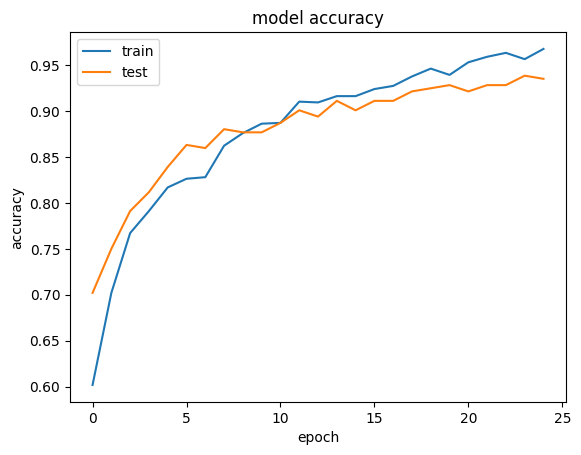

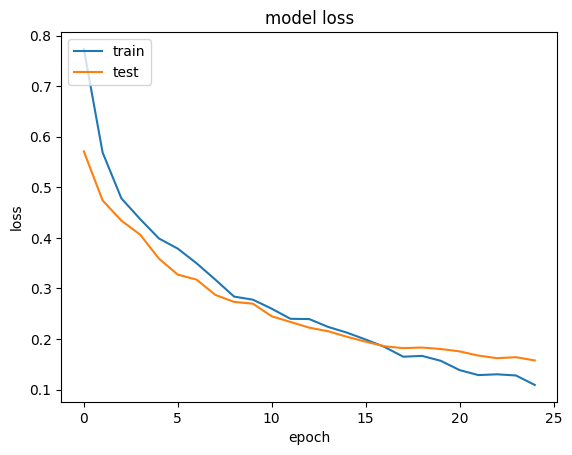

In [ ]:
print(hist.history.keys())

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


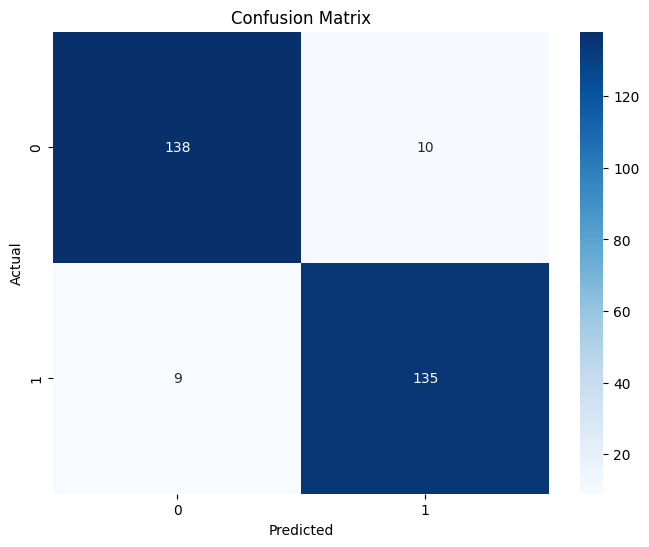

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       148
           1       0.93      0.94      0.93       144

    accuracy                           0.93       292
   macro avg       0.93      0.93      0.93       292
weighted avg       0.93      0.93      0.93       292



In [ ]:
y_pred = early_model.predict([X_audio_val, X_text_val])
y_pred_classes = (y_pred > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val, y_pred_classes))

## Модель пізнього злиття

In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.3)

    def call(self, inputs):
        attn_output = self.multi_head_attention(inputs, inputs)
        attn_output = self.dropout(attn_output)
        return self.layernorm(inputs + attn_output)

# Аудіо модель
def create_audio_model(input_shape):
    inputs = Input(shape=input_shape)
    # Перший шар CNN
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Другий шар CNN
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Bi-LSTM шар
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dropout(0.3)(x)

    outputs = Dense(64, activation='relu')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Текстова модель
def create_text_model(input_shape):
    inputs = Input(shape=input_shape)

    # Bi-LSTM шар
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)

    # Додавання механізму самоуваги
    x = SelfAttention(embed_dim=64, num_heads=4)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)

    outputs = Dense(64, activation='relu')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Створення моделі з пізнім ф'южном
def create_late_fusion_model(audio_input_shape, text_input_shape):
    audio_model = create_audio_model(audio_input_shape)
    text_model = create_text_model(text_input_shape)

    audio_input = Input(shape=audio_input_shape)
    text_input = Input(shape=text_input_shape)

    audio_features = audio_model(audio_input)
    text_features = text_model(text_input)

    # Пізнє об'єднання ознак
    combined_features = Concatenate()([audio_features, text_features])

    x = Dense(128, activation='relu')(combined_features)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[audio_input, text_input], outputs=output)
    return model

audio_input_shape = (None, 100)
text_input_shape = (None, 3000)

late_model = create_late_fusion_model(audio_input_shape, text_input_shape)

learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

late_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
late_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, None, 100)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, None, 3000)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 64)             │        278,016 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_5 (Functional) │ (None, 64)             │      1,713,920 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128)            │              0 │ functional_4[0][0],    │
│ (Concatenate)             │                        │                │ functional_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │         16,512 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 128)            │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1)              │            129 │ dropout_14[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,008,577 (7.66 MB)

 Trainable params: 2,008,193 (7.66 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
X_audio_train = np.expand_dims(X_audio_train, axis=1)
X_audio_val = np.expand_dims(X_audio_val, axis=1)
X_text_train = np.expand_dims(X_text_train, axis=-1)
X_text_val = np.expand_dims(X_text_val, axis=1)

In [ ]:
history = late_model.fit([X_audio_train, X_text_train], y_train, epochs=50, batch_size=16, validation_data=([X_audio_val, X_text_val], y_val))

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


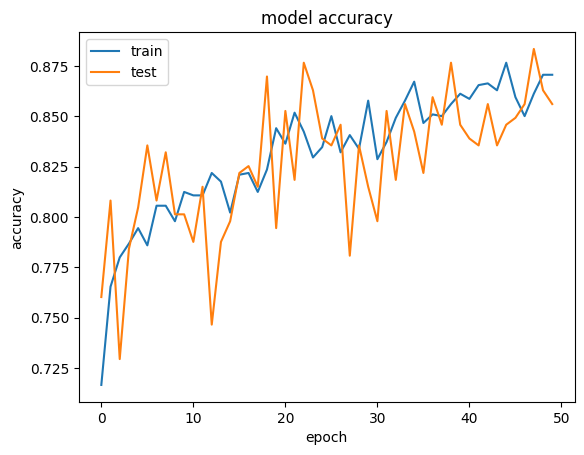

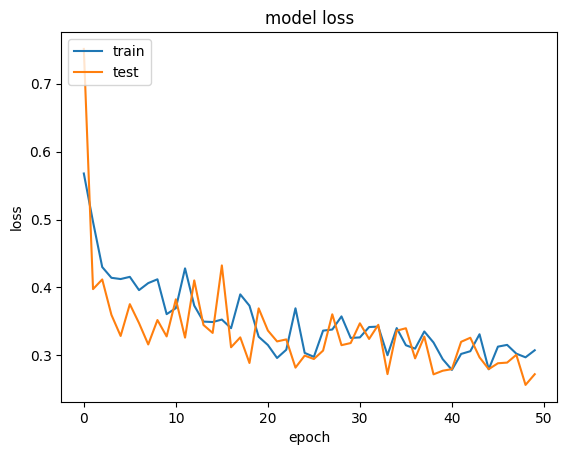

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion Matrix:


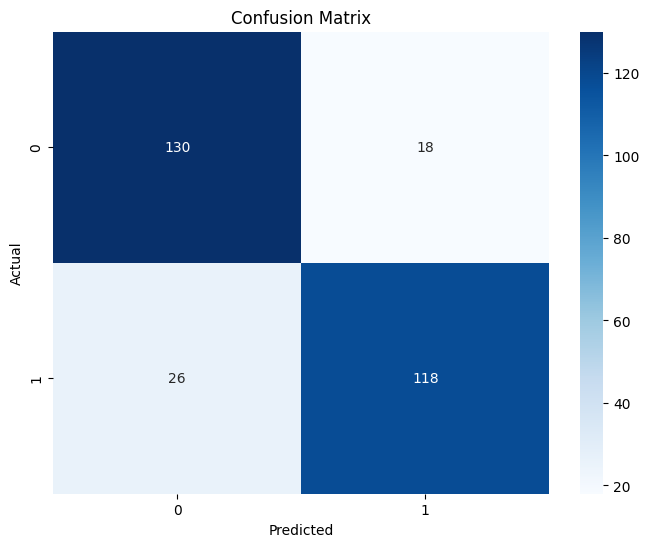


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.88      0.86       148
     Class 1       0.87      0.82      0.84       144

    accuracy                           0.85       292
   macro avg       0.85      0.85      0.85       292
weighted avg       0.85      0.85      0.85       292



In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:")
print(report)
X_audio_test1 = np.expand_dims(X_audio_test, axis=1)
X_text_test1 = np.expand_dims(X_text_test, axis=-1)
y_pred = late_model.predict([X_audio_test1, X_text_test1], batch_size=16)
y_pred_classes = (y_pred > 0.5).astype("int32")

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes, target_names=['Class 0', 'Class 1']))

## Тестування кращої моделі (модель раннього злиття)

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 410ms/step
Accuracy: 0.8604651162790697
Confusion Matrix:
[[26  4]
 [ 2 11]]


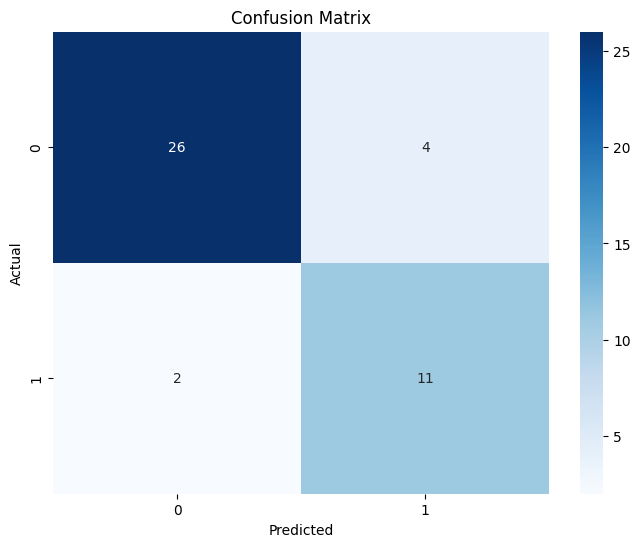

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.73      0.85      0.79        13

    accuracy                           0.86        43
   macro avg       0.83      0.86      0.84        43
weighted avg       0.87      0.86      0.86        43



In [ ]:
def aggregate_predictions(patient_ids, y_pred_segment_probs):

    predictions_df = pd.DataFrame({'patient_id': patient_ids, 'predicted_prob': y_pred_segment_probs})
    aggregated_predictions = predictions_df.groupby('patient_id')['predicted_prob'].mean()

    return aggregated_predictions

# Функція для оцінки моделі
def evaluate_model(model, X_test, y_test, patient_ids_test):

    y_pred_segment_probs = model.predict(X_test, batch_size=8).flatten()
    aggregated_predictions_probs = aggregate_predictions(patient_ids_test, y_pred_segment_probs)
    aggregated_predictions_classes = (aggregated_predictions_probs > 0.5).astype(int)

    # Реальні мітки на рівні пацієнта
    y_test_patient = pd.Series(y_test).groupby(patient_ids_test).first()

    # Оцінка моделі
    accuracy = accuracy_score(y_test_patient, aggregated_predictions_classes)
    conf_matrix = confusion_matrix(y_test_patient, aggregated_predictions_classes)
    report = classification_report(y_test_patient, aggregated_predictions_classes)

    print(f'Accuracy: {accuracy}')
    print('Confusion Matrix:')
    print(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    print('Classification Report:')
    print(report)

# Прогнозування та оцінка моделі
evaluate_model(early_model, [X_audio_test, X_text_test], test_labels, patient_ids_test)

In [ ]:
early_model.save('early_model.keras')